In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np

from PIL import Image

from torchvision import transforms
from torch.nn import Linear, Conv2d, ConvTranspose2d, Dropout, BatchNorm2d, LeakyReLU, ReLU
from typing import Tuple, List

from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torchvision

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

device

device(type='cuda')

In [20]:
class Sampling(nn.Module):
  def __init__(self, shape):
    super(Sampling, self).__init__()
    self.epsilon = nn.Parameter(torch.normal(mean=0.0, std=1.0, size=(shape,)))
    
  def forward(self, mu, log_var):
    return mu + torch.exp(log_var / 2) * self.epsilon


class Encoder(nn.Module):
  def __init__(self,
               input_dim: Tuple[int],
               encoder_conv_filters: List[int],
               encoder_conv_kernel_size: List[int],
               encoder_conv_strides: List[int],
               z_dim: int,
               use_batch_norm: bool = False,
               use_dropout: bool = False):
    super(Encoder, self).__init__()
    self.encoder_layers = [
      Conv2d(in_channels=input_dim[-1], 
          out_channels=encoder_conv_filters[0], 
          kernel_size=encoder_conv_kernel_size[0],
          stride=encoder_conv_strides[0],
          padding=1)
    ]
    for i in range(1, len(encoder_conv_filters)):
      self.encoder_layers.append(
          Conv2d(in_channels=encoder_conv_filters[i-1],
                 out_channels=encoder_conv_filters[i],
                 kernel_size=encoder_conv_kernel_size[i],
                 stride=encoder_conv_strides[i],
                 padding=1)    
      )

      self.encoder_layers.append(LeakyReLU())

      if use_batch_norm:
        self.encoder_layers.append(BatchNorm2d(num_features=encoder_conv_filters[i]))
      
      if use_dropout:
        self.encoder_layers.append(Dropout())
    
    self.encoder_layers = nn.ModuleList(self.encoder_layers)

    # self.fc = Linear(in_features=64 * 7 * 7, out_features=z_dim)

    # Outputting mu and log_var for each point in a latent space

    self.fc1 = Linear(in_features=64 * 7 * 7, out_features=z_dim)
    self.fc2 = Linear(in_features=64 * 7 * 7, out_features=z_dim)
    self.sampling = Sampling(shape=z_dim)

  def forward(self, x):
    for layer in self.encoder_layers:
      x = layer(x)
    
    self.shape_before_flatten = x.shape
    x = torch.flatten(x, start_dim=1)

    self.mu = self.fc1(x)
    self.log_var = self.fc2(x)

    x = self.sampling(self.mu, self.log_var)
    return x

  def kl_loss(self, y_true, y_pred):
    """
    Latent loss - Kullback-Leibler Divergence
    """
    # return -0.5 * torch.sum(1 + self.log_var - torch.square(self.mu) - torch.exp(self.log_var))
    return F.kl_div(y_pred, y_true)

  def mse_loss(self, y_true, y_pred):
    """
    Reconstruction/Generative loss - MSE loss
    """
    return torch.mean(torch.square(y_true - y_pred))


class Decoder(nn.Module):
  def __init__(self,
               decoder_conv_t_filters: List[int],
               decoder_conv_t_kernel_size: List[int],
               decoder_conv_t_strides: List[int],
               z_dim: int,
               use_batch_norm: bool = False,
               use_dropout: bool = False):
    super(Decoder, self).__init__()

    self._paddings = [1 for _ in decoder_conv_t_filters]
    self._o_paddings = [1 if decoder_conv_t_strides[i] > 1 else 0 for i in range(len(decoder_conv_t_filters))]

    self.shape_before_flatten = (-1, 64, 7, 7)
    self.fc = Linear(in_features=z_dim, out_features=np.prod(self.shape_before_flatten[1:]))
    self.decoder_layers = [
      ConvTranspose2d(in_channels=self.shape_before_flatten[1], 
                      out_channels=decoder_conv_t_filters[0], 
                      kernel_size=decoder_conv_t_kernel_size[0],
                      stride=decoder_conv_t_strides[0],
                      padding=self._paddings[0],
                      output_padding=self._o_paddings[0])
    ]

    for i in range(1, len(decoder_conv_t_filters)):
      self.decoder_layers.append(
        ConvTranspose2d(in_channels=decoder_conv_t_filters[i-1], 
                        out_channels=decoder_conv_t_filters[i], 
                        kernel_size=decoder_conv_t_kernel_size[i],
                        stride=decoder_conv_t_strides[i],
                        padding=self._paddings[i],
                        output_padding=self._o_paddings[i])
      )


      if i < len(decoder_conv_t_filters) - 1:
        self.decoder_layers.append(LeakyReLU())
      
    self.decoder_layers.append(ReLU())
    self.decoder_layers = nn.ModuleList(self.decoder_layers)

  def forward(self, x):
    x = self.fc(x)
    x = x.view(self.shape_before_flatten)
    for layer in self.decoder_layers:
      x = layer(x)

    return x


class AutoEncoder(nn.Module):
  def __init__(self,
               input_dim: Tuple[int],
               encoder_conv_filters: List[int],
               encoder_conv_kernel_size: List[int],
               encoder_conv_strides: List[int],
               decoder_conv_t_filters: List[int],
               decoder_conv_t_kernel_size: List[int],
               decoder_conv_t_strides: List[int],
               z_dim: int,
               device: str,
               use_batch_norm: bool = False,
               use_dropout: bool = False):
    super(AutoEncoder, self).__init__()
    self.encoder = Encoder(input_dim=input_dim,
                           encoder_conv_filters=encoder_conv_filters,
                           encoder_conv_kernel_size=encoder_conv_kernel_size,
                           encoder_conv_strides=encoder_conv_strides,
                           z_dim=z_dim)
    self.decoder = Decoder(decoder_conv_t_filters=decoder_conv_t_filters,
                           decoder_conv_t_kernel_size=decoder_conv_t_kernel_size,
                           decoder_conv_t_strides=decoder_conv_t_strides,
                           z_dim=z_dim)
    self.to(device)
    self.device = device

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  def loss_function(self, mse_loss_factor, y_true, y_pred):
    mse_loss = self.encoder.mse_loss(y_true, y_pred)
    kl_loss = self.encoder.kl_loss(y_true, y_pred)
    return mse_loss_factor * mse_loss + kl_loss, mse_loss, kl_loss

  def train(self, dataloader, epochs, learning_rate=1e-3, mse_loss_factor=10):
    train_losses = []
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    for epoch in tqdm(range(epochs)):
      epoch_loss, epoch_kl_loss, epoch_mse_loss = 0, 0, 0
      for i, (x, _) in enumerate(dataloader):
        optimizer.zero_grad()
        x = x.to(self.device)
        output = self.forward(x)
        loss, mse_loss, kl_loss = self.loss_function(mse_loss_factor, x, output)
        epoch_loss += loss.item()
        epoch_kl_loss += kl_loss.item()
        epoch_mse_loss += mse_loss.item()
        loss.backward()
        optimizer.step()
        if i % 500 == 0:
          print(f"general loss: {loss.item():4.8f}, mse: {mse_loss.item():4.8f}, kl: {kl_loss.item():4.8f}")
      epoch_loss /= len(dataloader)
      epoch_kl_loss /= len(dataloader)
      epoch_mse_loss /= len(dataloader)
      print(f"\nEpoch {epoch}: train_loss = {epoch_loss:4.8f}, mse_loss = {epoch_mse_loss:4.8f}, kl_loss={epoch_kl_loss:4.8f}")
      train_losses.append(epoch_loss)

    return train_losses

In [21]:
dataset = torchvision.datasets.MNIST(root=".", train=True, 
                                     transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))]),
                                     download=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

len(dataloader.dataset), len(dataloader)

(60000, 938)

In [22]:
autoencoder = AutoEncoder(input_dim=(28, 28, 1),
                          encoder_conv_filters=[32, 64, 64, 64],
                          encoder_conv_kernel_size=[3, 3, 3, 3],
                          encoder_conv_strides=[1, 2, 2, 1],
                          decoder_conv_t_filters=[64, 64, 32, 1],
                          decoder_conv_t_kernel_size=[3, 3, 3, 3],
                          decoder_conv_t_strides=[1, 2, 2, 1],
                          device=device,
                          z_dim=2)

In [23]:
train_losses = autoencoder.train(dataloader=dataloader, epochs=150, learning_rate=0.0005, mse_loss_factor=5000)

  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


general loss: 5439.91015625, mse: 1.08793736, kl: 0.22329961
general loss: 3119.44848633, mse: 0.62391299, kl: -0.11655774


  1%|          | 1/150 [00:17<43:27, 17.50s/it]


Epoch 0: train_loss = 3231.50548510, mse_loss = 0.64631916, kl_loss=-0.09030058
general loss: 3019.47705078, mse: 0.60392302, kl: -0.13823338
general loss: 2783.61157227, mse: 0.55675811, kl: -0.17897491


  1%|▏         | 2/150 [00:34<43:05, 17.47s/it]


Epoch 1: train_loss = 2911.27885648, mse_loss = 0.58228565, kl_loss=-0.14940263
general loss: 2973.89721680, mse: 0.59481174, kl: -0.16132419
general loss: 3004.38525391, mse: 0.60091209, kl: -0.17525898


  2%|▏         | 3/150 [00:51<42:08, 17.20s/it]


Epoch 2: train_loss = 2823.07866273, mse_loss = 0.56464895, kl_loss=-0.16609449
general loss: 2774.15576172, mse: 0.55486482, kl: -0.16851725
general loss: 2751.59741211, mse: 0.55036473, kl: -0.22638127


  3%|▎         | 4/150 [01:09<41:56, 17.23s/it]


Epoch 3: train_loss = 2771.46173447, mse_loss = 0.55432756, kl_loss=-0.17605632
general loss: 2515.35668945, mse: 0.50310326, kl: -0.15971364
general loss: 2607.27075195, mse: 0.52149773, kl: -0.21769625


  3%|▎         | 5/150 [01:26<41:46, 17.29s/it]


Epoch 4: train_loss = 2734.92120817, mse_loss = 0.54702080, kl_loss=-0.18278947
general loss: 2761.21020508, mse: 0.55228049, kl: -0.19219360
general loss: 2557.54614258, mse: 0.51154512, kl: -0.17955253


  4%|▍         | 6/150 [01:43<41:33, 17.31s/it]


Epoch 5: train_loss = 2708.27834296, mse_loss = 0.54169324, kl_loss=-0.18786994
general loss: 2655.45849609, mse: 0.53113991, kl: -0.24090081
general loss: 2588.10839844, mse: 0.51766187, kl: -0.20095389


  5%|▍         | 7/150 [02:00<40:32, 17.01s/it]


Epoch 6: train_loss = 2683.76838603, mse_loss = 0.53679218, kl_loss=-0.19251094
general loss: 2635.58251953, mse: 0.52715278, kl: -0.18146592
general loss: 2527.63916016, mse: 0.50557172, kl: -0.21946318


  5%|▌         | 8/150 [02:16<39:54, 16.87s/it]


Epoch 7: train_loss = 2661.92008247, mse_loss = 0.53242336, kl_loss=-0.19670298
general loss: 2637.74902344, mse: 0.52759361, kl: -0.21891846
general loss: 2559.23706055, mse: 0.51188678, kl: -0.19677463


  6%|▌         | 9/150 [02:33<39:47, 16.93s/it]


Epoch 8: train_loss = 2648.23781822, mse_loss = 0.52968742, kl_loss=-0.19928833
general loss: 2612.34301758, mse: 0.52251440, kl: -0.22892392
general loss: 2726.39990234, mse: 0.54531235, kl: -0.16186976


  7%|▋         | 10/150 [02:51<39:41, 17.01s/it]


Epoch 9: train_loss = 2632.64037800, mse_loss = 0.52656850, kl_loss=-0.20212054
general loss: 2641.23168945, mse: 0.52829301, kl: -0.23351479
general loss: 2409.89648438, mse: 0.48202401, kl: -0.22369614


  7%|▋         | 11/150 [03:08<39:25, 17.02s/it]


Epoch 10: train_loss = 2619.99185539, mse_loss = 0.52403932, kl_loss=-0.20476347
general loss: 2704.20214844, mse: 0.54088587, kl: -0.22722708
general loss: 2672.69799805, mse: 0.53458428, kl: -0.22343768


  8%|▊         | 12/150 [03:25<39:05, 16.99s/it]


Epoch 11: train_loss = 2607.11662035, mse_loss = 0.52146477, kl_loss=-0.20724948
general loss: 2656.20117188, mse: 0.53128463, kl: -0.22189257
general loss: 2686.60986328, mse: 0.53735495, kl: -0.16475721


  9%|▊         | 13/150 [03:41<38:44, 16.97s/it]


Epoch 12: train_loss = 2599.55946698, mse_loss = 0.51995361, kl_loss=-0.20859302
general loss: 2466.05444336, mse: 0.49325210, kl: -0.20611413
general loss: 2573.51538086, mse: 0.51474494, kl: -0.20933031


  9%|▉         | 14/150 [03:59<38:43, 17.09s/it]


Epoch 13: train_loss = 2589.73135343, mse_loss = 0.51798835, kl_loss=-0.21039297
general loss: 2437.53515625, mse: 0.48755270, kl: -0.22825420
general loss: 2550.41113281, mse: 0.51012546, kl: -0.21599567


 10%|█         | 15/150 [04:16<38:27, 17.10s/it]


Epoch 14: train_loss = 2583.59578303, mse_loss = 0.51676149, kl_loss=-0.21167208
general loss: 2610.81250000, mse: 0.52220052, kl: -0.19014218
general loss: 2477.72119141, mse: 0.49559432, kl: -0.25047475


 11%|█         | 16/150 [04:33<38:15, 17.13s/it]


Epoch 15: train_loss = 2576.05945631, mse_loss = 0.51525448, kl_loss=-0.21294650
general loss: 2550.17431641, mse: 0.51007414, kl: -0.19626065
general loss: 2613.84472656, mse: 0.52281374, kl: -0.22387131


 11%|█▏        | 17/150 [04:51<38:13, 17.25s/it]


Epoch 16: train_loss = 2566.94204523, mse_loss = 0.51343134, kl_loss=-0.21462719
general loss: 2410.94921875, mse: 0.48223028, kl: -0.20214830
general loss: 2452.35327148, mse: 0.49050802, kl: -0.18681952


 12%|█▏        | 18/150 [05:08<37:44, 17.15s/it]


Epoch 17: train_loss = 2562.22326660, mse_loss = 0.51248776, kl_loss=-0.21554099
general loss: 2412.76098633, mse: 0.48259458, kl: -0.21185014
general loss: 2605.33203125, mse: 0.52110952, kl: -0.21565093


 13%|█▎        | 19/150 [05:25<37:35, 17.22s/it]


Epoch 18: train_loss = 2555.69801601, mse_loss = 0.51118294, kl_loss=-0.21668648
general loss: 2529.93603516, mse: 0.50602913, kl: -0.20981079
general loss: 2444.54418945, mse: 0.48894966, kl: -0.20406729


 13%|█▎        | 20/150 [05:43<37:42, 17.40s/it]


Epoch 19: train_loss = 2547.21212046, mse_loss = 0.50948609, kl_loss=-0.21834585
general loss: 2739.70678711, mse: 0.54798841, kl: -0.23532419
general loss: 2664.82373047, mse: 0.53300953, kl: -0.22394900


 14%|█▍        | 21/150 [06:00<37:13, 17.32s/it]


Epoch 20: train_loss = 2545.24029086, mse_loss = 0.50909183, kl_loss=-0.21887073
general loss: 2487.16552734, mse: 0.49747548, kl: -0.21189661
general loss: 2751.68188477, mse: 0.55037344, kl: -0.18532985


 15%|█▍        | 22/150 [06:17<36:45, 17.23s/it]


Epoch 21: train_loss = 2539.01677465, mse_loss = 0.50784737, kl_loss=-0.22008381
general loss: 2477.53369141, mse: 0.49555594, kl: -0.24621369
general loss: 2506.76660156, mse: 0.50140113, kl: -0.23895617


 15%|█▌        | 23/150 [06:34<36:38, 17.31s/it]


Epoch 22: train_loss = 2537.63896859, mse_loss = 0.50757187, kl_loss=-0.22038809
general loss: 2515.54174805, mse: 0.50315368, kl: -0.22653735
general loss: 2657.45043945, mse: 0.53152788, kl: -0.18906321


 16%|█▌        | 24/150 [06:52<36:37, 17.44s/it]


Epoch 23: train_loss = 2530.44161213, mse_loss = 0.50613263, kl_loss=-0.22150765
general loss: 2525.93994141, mse: 0.50523096, kl: -0.21490583
general loss: 2584.18969727, mse: 0.51688659, kl: -0.24309975


 17%|█▋        | 25/150 [07:10<36:22, 17.46s/it]


Epoch 24: train_loss = 2523.67923826, mse_loss = 0.50478041, kl_loss=-0.22279132
general loss: 2204.82470703, mse: 0.44101831, kl: -0.26694614
general loss: 2504.40771484, mse: 0.50091577, kl: -0.17121914


 17%|█▋        | 26/150 [07:27<36:09, 17.49s/it]


Epoch 25: train_loss = 2517.40380911, mse_loss = 0.50352561, kl_loss=-0.22422182
general loss: 2453.35473633, mse: 0.49071342, kl: -0.21251355
general loss: 2536.67846680, mse: 0.50738215, kl: -0.23233284


 18%|█▊        | 27/150 [07:45<35:55, 17.52s/it]


Epoch 26: train_loss = 2512.16263644, mse_loss = 0.50247751, kl_loss=-0.22493110
general loss: 2442.88916016, mse: 0.48861554, kl: -0.18842857
general loss: 2538.12792969, mse: 0.50768000, kl: -0.27196464


 19%|█▊        | 28/150 [08:02<35:28, 17.45s/it]


Epoch 27: train_loss = 2511.61041273, mse_loss = 0.50236714, kl_loss=-0.22528654
general loss: 2524.64208984, mse: 0.50497687, kl: -0.24209356
general loss: 2420.24926758, mse: 0.48409706, kl: -0.23617211


 19%|█▉        | 29/150 [08:20<35:16, 17.49s/it]


Epoch 28: train_loss = 2506.24380513, mse_loss = 0.50129398, kl_loss=-0.22608186
general loss: 2550.00781250, mse: 0.51005250, kl: -0.25475642
general loss: 2740.96337891, mse: 0.54823464, kl: -0.20972168


 20%|██        | 30/150 [08:37<34:54, 17.46s/it]


Epoch 29: train_loss = 2501.96215378, mse_loss = 0.50043784, kl_loss=-0.22704777
general loss: 2520.61547852, mse: 0.50415593, kl: -0.16429259
general loss: 2614.05688477, mse: 0.52286071, kl: -0.24659140


 21%|██        | 31/150 [08:55<34:36, 17.45s/it]


Epoch 30: train_loss = 2498.02155361, mse_loss = 0.49964982, kl_loss=-0.22755845
general loss: 2408.71459961, mse: 0.48179096, kl: -0.24014640
general loss: 2383.77270508, mse: 0.47680336, kl: -0.24420059


 21%|██▏       | 32/150 [09:12<34:05, 17.34s/it]


Epoch 31: train_loss = 2494.99675069, mse_loss = 0.49904497, kl_loss=-0.22808938
general loss: 2338.27368164, mse: 0.46771392, kl: -0.29580986
general loss: 2359.84692383, mse: 0.47201723, kl: -0.23922259


 22%|██▏       | 33/150 [09:29<33:42, 17.28s/it]


Epoch 32: train_loss = 2492.18143475, mse_loss = 0.49848203, kl_loss=-0.22869605
general loss: 2543.42431641, mse: 0.50873405, kl: -0.24583913
general loss: 2571.28588867, mse: 0.51430309, kl: -0.22944021


 23%|██▎       | 34/150 [09:46<33:29, 17.32s/it]


Epoch 33: train_loss = 2492.35627431, mse_loss = 0.49851700, kl_loss=-0.22873982
general loss: 2380.15722656, mse: 0.47608235, kl: -0.25473115
general loss: 2460.77001953, mse: 0.49220347, kl: -0.24720816


 23%|██▎       | 35/150 [10:04<33:17, 17.37s/it]


Epoch 34: train_loss = 2486.79130610, mse_loss = 0.49740421, kl_loss=-0.22976059
general loss: 2384.26513672, mse: 0.47689366, kl: -0.20301647
general loss: 2434.23608398, mse: 0.48689947, kl: -0.26116928


 24%|██▍       | 36/150 [10:21<33:05, 17.41s/it]


Epoch 35: train_loss = 2483.14616241, mse_loss = 0.49667531, kl_loss=-0.23036362
general loss: 2449.55664062, mse: 0.48995745, kl: -0.23064591
general loss: 2597.31298828, mse: 0.51951236, kl: -0.24867041


 25%|██▍       | 37/150 [10:38<32:29, 17.25s/it]


Epoch 36: train_loss = 2482.94356890, mse_loss = 0.49663478, kl_loss=-0.23034365
general loss: 2598.69799805, mse: 0.51978809, kl: -0.24239120
general loss: 2550.71362305, mse: 0.51019311, kl: -0.25184837


 25%|██▌       | 38/150 [10:55<31:49, 17.05s/it]


Epoch 37: train_loss = 2481.39277073, mse_loss = 0.49632469, kl_loss=-0.23065574
general loss: 2379.08764648, mse: 0.47586277, kl: -0.22628988
general loss: 2479.50512695, mse: 0.49594909, kl: -0.24016292


 26%|██▌       | 39/150 [11:12<31:46, 17.17s/it]


Epoch 38: train_loss = 2475.62804473, mse_loss = 0.49517196, kl_loss=-0.23177611
general loss: 2374.85034180, mse: 0.47501847, kl: -0.24201497
general loss: 2470.42773438, mse: 0.49412808, kl: -0.21276431


 27%|██▋       | 40/150 [11:30<31:45, 17.32s/it]


Epoch 39: train_loss = 2471.66804996, mse_loss = 0.49438011, kl_loss=-0.23249521
general loss: 2330.88989258, mse: 0.46622965, kl: -0.25836572
general loss: 2619.48266602, mse: 0.52394283, kl: -0.23137495


 27%|██▋       | 41/150 [11:47<31:30, 17.35s/it]


Epoch 40: train_loss = 2468.09660733, mse_loss = 0.49366593, kl_loss=-0.23304145
general loss: 2568.94702148, mse: 0.51383060, kl: -0.20613298
general loss: 2581.40478516, mse: 0.51633662, kl: -0.27843758


 28%|██▊       | 42/150 [12:04<30:55, 17.18s/it]


Epoch 41: train_loss = 2469.46620891, mse_loss = 0.49393980, kl_loss=-0.23279674
general loss: 2262.19750977, mse: 0.45249230, kl: -0.26400468
general loss: 2469.23730469, mse: 0.49389306, kl: -0.22792712


 29%|██▊       | 43/150 [12:21<30:44, 17.24s/it]


Epoch 42: train_loss = 2467.90729580, mse_loss = 0.49362810, kl_loss=-0.23319065
general loss: 2398.19970703, mse: 0.47968096, kl: -0.20500927
general loss: 2660.15527344, mse: 0.53208166, kl: -0.25294930


 29%|██▉       | 44/150 [12:39<30:45, 17.41s/it]


Epoch 43: train_loss = 2463.86495145, mse_loss = 0.49281977, kl_loss=-0.23388947
general loss: 2513.74853516, mse: 0.50279891, kl: -0.24607795
general loss: 2537.79760742, mse: 0.50760752, kl: -0.24005274


 30%|███       | 45/150 [12:57<30:44, 17.56s/it]


Epoch 44: train_loss = 2461.54728806, mse_loss = 0.49235631, kl_loss=-0.23423395
general loss: 2433.76782227, mse: 0.48679453, kl: -0.20487595
general loss: 2277.61791992, mse: 0.45558229, kl: -0.29348987


 31%|███       | 46/150 [13:14<30:16, 17.47s/it]


Epoch 45: train_loss = 2460.36350223, mse_loss = 0.49211961, kl_loss=-0.23452406
general loss: 2452.48730469, mse: 0.49054733, kl: -0.24928059
general loss: 2595.46679688, mse: 0.51914304, kl: -0.24849434


 31%|███▏      | 47/150 [13:32<30:03, 17.51s/it]


Epoch 46: train_loss = 2459.37513144, mse_loss = 0.49192196, kl_loss=-0.23465301
general loss: 2356.76538086, mse: 0.47139594, kl: -0.21427010
general loss: 2521.01684570, mse: 0.50425267, kl: -0.24668257


 32%|███▏      | 48/150 [13:49<29:42, 17.48s/it]


Epoch 47: train_loss = 2455.84814713, mse_loss = 0.49121669, kl_loss=-0.23531879
general loss: 2366.82617188, mse: 0.47340813, kl: -0.21463336
general loss: 2365.65405273, mse: 0.47317636, kl: -0.22789192


 33%|███▎      | 49/150 [14:07<29:28, 17.51s/it]


Epoch 48: train_loss = 2453.59504410, mse_loss = 0.49076617, kl_loss=-0.23580751
general loss: 2387.76342773, mse: 0.47759670, kl: -0.21998551
general loss: 2511.68505859, mse: 0.50237846, kl: -0.20718889


 33%|███▎      | 50/150 [14:25<29:21, 17.61s/it]


Epoch 49: train_loss = 2453.49992842, mse_loss = 0.49074715, kl_loss=-0.23580554
general loss: 2583.68237305, mse: 0.51678038, kl: -0.21940736
general loss: 2406.29345703, mse: 0.48130333, kl: -0.22325948


 34%|███▍      | 51/150 [14:42<29:01, 17.59s/it]


Epoch 50: train_loss = 2452.15250252, mse_loss = 0.49047768, kl_loss=-0.23591693
general loss: 2332.39111328, mse: 0.46652821, kl: -0.25002071
general loss: 2462.35546875, mse: 0.49251509, kl: -0.21985687


 35%|███▍      | 52/150 [15:00<28:36, 17.52s/it]


Epoch 51: train_loss = 2450.16701223, mse_loss = 0.49008068, kl_loss=-0.23637221
general loss: 2243.39208984, mse: 0.44872823, kl: -0.24891740
general loss: 2427.73925781, mse: 0.48558438, kl: -0.18265495


 35%|███▌      | 53/150 [15:17<28:18, 17.51s/it]


Epoch 52: train_loss = 2445.40566073, mse_loss = 0.48912858, kl_loss=-0.23725395
general loss: 2404.81958008, mse: 0.48101479, kl: -0.25448391
general loss: 2422.83300781, mse: 0.48462030, kl: -0.26852843


 36%|███▌      | 54/150 [15:34<27:46, 17.36s/it]


Epoch 53: train_loss = 2442.64511271, mse_loss = 0.48857657, kl_loss=-0.23771618
general loss: 2497.74487305, mse: 0.49959221, kl: -0.21628903
general loss: 2456.08740234, mse: 0.49126628, kl: -0.24393441


 37%|███▋      | 55/150 [15:51<27:21, 17.28s/it]


Epoch 54: train_loss = 2441.28237700, mse_loss = 0.48830409, kl_loss=-0.23806446
general loss: 2630.90649414, mse: 0.52622527, kl: -0.21990575
general loss: 2478.04785156, mse: 0.49565679, kl: -0.23598316


 37%|███▋      | 56/150 [16:09<27:07, 17.31s/it]


Epoch 55: train_loss = 2439.71625784, mse_loss = 0.48799092, kl_loss=-0.23833190
general loss: 2369.03344727, mse: 0.47384736, kl: -0.20334698
general loss: 2482.86035156, mse: 0.49662787, kl: -0.27902097


 38%|███▊      | 57/150 [16:26<26:47, 17.28s/it]


Epoch 56: train_loss = 2443.34225913, mse_loss = 0.48871598, kl_loss=-0.23761746
general loss: 2584.25805664, mse: 0.51689839, kl: -0.23381528
general loss: 2462.59814453, mse: 0.49256885, kl: -0.24606796


 39%|███▊      | 58/150 [16:43<26:37, 17.36s/it]


Epoch 57: train_loss = 2438.16026869, mse_loss = 0.48767978, kl_loss=-0.23862901
general loss: 2293.29296875, mse: 0.45870987, kl: -0.25641391
general loss: 2459.86816406, mse: 0.49201420, kl: -0.20288925


 39%|███▉      | 59/150 [17:01<26:14, 17.31s/it]


Epoch 58: train_loss = 2435.35059635, mse_loss = 0.48711792, kl_loss=-0.23897441
general loss: 2468.65087891, mse: 0.49377036, kl: -0.20084740
general loss: 2550.12036133, mse: 0.51007169, kl: -0.23802990


 40%|████      | 60/150 [17:18<26:02, 17.36s/it]


Epoch 59: train_loss = 2434.63072741, mse_loss = 0.48697398, kl_loss=-0.23919619
general loss: 2591.48608398, mse: 0.51834774, kl: -0.25279808
general loss: 2542.12036133, mse: 0.50846690, kl: -0.21404724


 41%|████      | 61/150 [17:35<25:33, 17.23s/it]


Epoch 60: train_loss = 2434.53673457, mse_loss = 0.48695520, kl_loss=-0.23926945
general loss: 2357.45971680, mse: 0.47154650, kl: -0.27281281
general loss: 2383.38012695, mse: 0.47673118, kl: -0.27598667


 41%|████▏     | 62/150 [17:52<25:21, 17.29s/it]


Epoch 61: train_loss = 2431.59151682, mse_loss = 0.48636624, kl_loss=-0.23967938
general loss: 2544.08129883, mse: 0.50886685, kl: -0.25290462
general loss: 2348.46044922, mse: 0.46974745, kl: -0.27687261


 42%|████▏     | 63/150 [18:10<25:08, 17.34s/it]


Epoch 62: train_loss = 2439.66177986, mse_loss = 0.48798005, kl_loss=-0.23845093
general loss: 2546.37158203, mse: 0.50931275, kl: -0.19216229
general loss: 2296.54418945, mse: 0.45935369, kl: -0.22407088


 43%|████▎     | 64/150 [18:27<24:40, 17.22s/it]


Epoch 63: train_loss = 2435.68093137, mse_loss = 0.48718399, kl_loss=-0.23900221
general loss: 2610.00659180, mse: 0.52204931, kl: -0.24005540
general loss: 2673.14526367, mse: 0.53466940, kl: -0.20155556


 43%|████▎     | 65/150 [18:44<24:17, 17.15s/it]


Epoch 64: train_loss = 2426.68308439, mse_loss = 0.48538475, kl_loss=-0.24064422
general loss: 2538.52490234, mse: 0.50774741, kl: -0.21217839
general loss: 2550.44189453, mse: 0.51013410, kl: -0.22850884


 44%|████▍     | 66/150 [19:01<24:03, 17.18s/it]


Epoch 65: train_loss = 2427.39513301, mse_loss = 0.48552712, kl_loss=-0.24047530
general loss: 2404.18188477, mse: 0.48088270, kl: -0.23172748
general loss: 2261.49169922, mse: 0.45234722, kl: -0.24439733


 45%|████▍     | 67/150 [19:18<23:45, 17.18s/it]


Epoch 66: train_loss = 2422.95090795, mse_loss = 0.48463844, kl_loss=-0.24129773
general loss: 2344.72607422, mse: 0.46899521, kl: -0.25009534
general loss: 2359.37304688, mse: 0.47192883, kl: -0.27131733


 45%|████▌     | 68/150 [19:35<23:23, 17.11s/it]


Epoch 67: train_loss = 2422.95271038, mse_loss = 0.48463884, kl_loss=-0.24151097
general loss: 2357.17700195, mse: 0.47147575, kl: -0.20168534
general loss: 2405.25976562, mse: 0.48110089, kl: -0.24456322


 46%|████▌     | 69/150 [19:52<23:10, 17.17s/it]


Epoch 68: train_loss = 2423.72411381, mse_loss = 0.48479306, kl_loss=-0.24116586
general loss: 2467.17065430, mse: 0.49348074, kl: -0.23305632
general loss: 2363.22387695, mse: 0.47269213, kl: -0.23676930


 47%|████▋     | 70/150 [20:10<23:03, 17.29s/it]


Epoch 69: train_loss = 2420.22235381, mse_loss = 0.48409285, kl_loss=-0.24191802
general loss: 2348.37915039, mse: 0.46972319, kl: -0.23683251
general loss: 2430.79882812, mse: 0.48621535, kl: -0.27790558


 47%|████▋     | 71/150 [20:27<22:45, 17.28s/it]


Epoch 70: train_loss = 2418.40925673, mse_loss = 0.48373029, kl_loss=-0.24219723
general loss: 2319.76660156, mse: 0.46400097, kl: -0.23831044
general loss: 2423.42675781, mse: 0.48473600, kl: -0.25318027


 48%|████▊     | 72/150 [20:45<22:27, 17.27s/it]


Epoch 71: train_loss = 2420.08861628, mse_loss = 0.48406612, kl_loss=-0.24196825
general loss: 2444.17919922, mse: 0.48888272, kl: -0.23429239
general loss: 2203.01171875, mse: 0.44065174, kl: -0.24715154


 49%|████▊     | 73/150 [21:02<22:03, 17.19s/it]


Epoch 72: train_loss = 2415.09798862, mse_loss = 0.48306815, kl_loss=-0.24274859
general loss: 2537.77636719, mse: 0.50760871, kl: -0.26709849
general loss: 2177.11694336, mse: 0.43547165, kl: -0.24132623


 49%|████▉     | 74/150 [21:19<21:46, 17.20s/it]


Epoch 73: train_loss = 2415.12369393, mse_loss = 0.48307332, kl_loss=-0.24288866
general loss: 2402.96093750, mse: 0.48063970, kl: -0.23753986
general loss: 2480.36938477, mse: 0.49612784, kl: -0.26968834


 50%|█████     | 75/150 [21:36<21:30, 17.21s/it]


Epoch 74: train_loss = 2418.92431771, mse_loss = 0.48383329, kl_loss=-0.24215122
general loss: 2524.69091797, mse: 0.50498629, kl: -0.24042432
general loss: 2480.14404297, mse: 0.49606940, kl: -0.20289971


 51%|█████     | 76/150 [21:53<21:16, 17.25s/it]


Epoch 75: train_loss = 2415.51868925, mse_loss = 0.48315232, kl_loss=-0.24289103
general loss: 2672.59350586, mse: 0.53455949, kl: -0.20382303
general loss: 2478.56054688, mse: 0.49575973, kl: -0.23815286


 51%|█████▏    | 77/150 [22:11<21:07, 17.36s/it]


Epoch 76: train_loss = 2411.07008996, mse_loss = 0.48226271, kl_loss=-0.24344498
general loss: 2541.45214844, mse: 0.50833309, kl: -0.21343745
general loss: 2432.39282227, mse: 0.48652282, kl: -0.22121213


 52%|█████▏    | 78/150 [22:28<20:44, 17.28s/it]


Epoch 77: train_loss = 2419.68896667, mse_loss = 0.48398620, kl_loss=-0.24203929
general loss: 2494.77587891, mse: 0.49900094, kl: -0.22865941
general loss: 2465.77978516, mse: 0.49321142, kl: -0.27735096


 53%|█████▎    | 79/150 [22:45<20:21, 17.20s/it]


Epoch 78: train_loss = 2412.31061819, mse_loss = 0.48251080, kl_loss=-0.24335229
general loss: 2377.88208008, mse: 0.47562486, kl: -0.24227868
general loss: 2342.77270508, mse: 0.46860331, kl: -0.24382956


 53%|█████▎    | 80/150 [23:02<20:00, 17.15s/it]


Epoch 79: train_loss = 2412.90356159, mse_loss = 0.48262936, kl_loss=-0.24322249
general loss: 2404.94873047, mse: 0.48104018, kl: -0.25230151
general loss: 2269.05981445, mse: 0.45385975, kl: -0.23902500


 54%|█████▍    | 81/150 [23:19<19:38, 17.09s/it]


Epoch 80: train_loss = 2407.51359796, mse_loss = 0.48155159, kl_loss=-0.24433465
general loss: 2454.00634766, mse: 0.49084759, kl: -0.23175110
general loss: 2285.57543945, mse: 0.45717049, kl: -0.27700588


 55%|█████▍    | 82/150 [23:36<19:24, 17.12s/it]


Epoch 81: train_loss = 2412.23612094, mse_loss = 0.48249588, kl_loss=-0.24329234
general loss: 2511.67553711, mse: 0.50238699, kl: -0.25921810
general loss: 2623.91845703, mse: 0.52483010, kl: -0.23210546


 55%|█████▌    | 83/150 [23:53<19:05, 17.10s/it]


Epoch 82: train_loss = 2404.03094391, mse_loss = 0.48085516, kl_loss=-0.24487044
general loss: 2477.27783203, mse: 0.49550471, kl: -0.24567790
general loss: 2455.52099609, mse: 0.49114603, kl: -0.20924424


 56%|█████▌    | 84/150 [24:10<18:50, 17.13s/it]


Epoch 83: train_loss = 2408.69697281, mse_loss = 0.48178821, kl_loss=-0.24406060
general loss: 2348.87109375, mse: 0.46982947, kl: -0.27647772
general loss: 2454.35546875, mse: 0.49091956, kl: -0.24254709


 57%|█████▋    | 85/150 [24:28<18:39, 17.22s/it]


Epoch 84: train_loss = 2401.32590587, mse_loss = 0.48031424, kl_loss=-0.24528445
general loss: 2422.95288086, mse: 0.48463798, kl: -0.23717566
general loss: 2171.29760742, mse: 0.43431312, kl: -0.26809600


 57%|█████▋    | 86/150 [24:45<18:24, 17.26s/it]


Epoch 85: train_loss = 2401.20144881, mse_loss = 0.48028936, kl_loss=-0.24532990
general loss: 2383.69409180, mse: 0.47679344, kl: -0.27315527
general loss: 2183.33374023, mse: 0.43672308, kl: -0.28169098


 58%|█████▊    | 87/150 [25:03<18:07, 17.27s/it]


Epoch 86: train_loss = 2400.52157703, mse_loss = 0.48015341, kl_loss=-0.24547375
general loss: 2486.77099609, mse: 0.49740863, kl: -0.27210349
general loss: 2259.65087891, mse: 0.45198557, kl: -0.27676129


 59%|█████▊    | 88/150 [25:19<17:39, 17.10s/it]


Epoch 87: train_loss = 2400.83993433, mse_loss = 0.48021710, kl_loss=-0.24556789
general loss: 2357.28515625, mse: 0.47151050, kl: -0.26725745
general loss: 2144.51562500, mse: 0.42894548, kl: -0.21178249


 59%|█████▉    | 89/150 [25:36<17:24, 17.12s/it]


Epoch 88: train_loss = 2398.12002323, mse_loss = 0.47967318, kl_loss=-0.24589036
general loss: 2476.38012695, mse: 0.49532944, kl: -0.26718011
general loss: 2208.62475586, mse: 0.44178316, kl: -0.29108414


 60%|██████    | 90/150 [25:54<17:08, 17.14s/it]


Epoch 89: train_loss = 2397.93680558, mse_loss = 0.47963657, kl_loss=-0.24604620
general loss: 2239.65209961, mse: 0.44798243, kl: -0.26001051
general loss: 2428.91503906, mse: 0.48583719, kl: -0.27094185


 61%|██████    | 91/150 [26:11<16:58, 17.27s/it]


Epoch 90: train_loss = 2397.24931339, mse_loss = 0.47949910, kl_loss=-0.24618003
general loss: 2316.59863281, mse: 0.46337295, kl: -0.26615080
general loss: 2370.39721680, mse: 0.47413549, kl: -0.28024489


 61%|██████▏   | 92/150 [26:29<16:46, 17.35s/it]


Epoch 91: train_loss = 2398.29823157, mse_loss = 0.47970883, kl_loss=-0.24591351
general loss: 2442.45605469, mse: 0.48853177, kl: -0.20276155
general loss: 2407.06396484, mse: 0.48146421, kl: -0.25710464


 62%|██████▏   | 93/150 [26:46<16:31, 17.40s/it]


Epoch 92: train_loss = 2396.36769374, mse_loss = 0.47932278, kl_loss=-0.24622227
general loss: 2520.43823242, mse: 0.50413316, kl: -0.22755237
general loss: 2344.12573242, mse: 0.46887478, kl: -0.24832347


 63%|██████▎   | 94/150 [27:04<16:18, 17.47s/it]


Epoch 93: train_loss = 2392.51175883, mse_loss = 0.47855174, kl_loss=-0.24694930
general loss: 2281.49096680, mse: 0.45634773, kl: -0.24783473
general loss: 2354.57934570, mse: 0.47096244, kl: -0.23299442


 63%|██████▎   | 95/150 [27:21<15:51, 17.30s/it]


Epoch 94: train_loss = 2397.72105892, mse_loss = 0.47959342, kl_loss=-0.24604416
general loss: 2464.84912109, mse: 0.49302626, kl: -0.28227648
general loss: 2334.70239258, mse: 0.46700013, kl: -0.29832405


 64%|██████▍   | 96/150 [27:38<15:35, 17.32s/it]


Epoch 95: train_loss = 2393.45507526, mse_loss = 0.47874039, kl_loss=-0.24686708
general loss: 2236.99902344, mse: 0.44745249, kl: -0.26345333
general loss: 2548.71362305, mse: 0.50979686, kl: -0.27082297


 65%|██████▍   | 97/150 [27:55<15:07, 17.12s/it]


Epoch 96: train_loss = 2393.08836980, mse_loss = 0.47866706, kl_loss=-0.24693405
general loss: 2376.97265625, mse: 0.47543973, kl: -0.22610550
general loss: 2357.02124023, mse: 0.47144935, kl: -0.22566332


 65%|██████▌   | 98/150 [28:12<14:54, 17.19s/it]


Epoch 97: train_loss = 2391.64410518, mse_loss = 0.47837825, kl_loss=-0.24715305
general loss: 2412.61694336, mse: 0.48257008, kl: -0.23333374
general loss: 2343.87963867, mse: 0.46882272, kl: -0.23377831


 66%|██████▌   | 99/150 [28:29<14:35, 17.16s/it]


Epoch 98: train_loss = 2393.27478626, mse_loss = 0.47870431, kl_loss=-0.24676808
general loss: 2364.94653320, mse: 0.47304231, kl: -0.26496318
general loss: 2392.78149414, mse: 0.47860265, kl: -0.23158211


 67%|██████▋   | 100/150 [28:47<14:22, 17.26s/it]


Epoch 99: train_loss = 2392.37568635, mse_loss = 0.47852456, kl_loss=-0.24713158
general loss: 2333.24755859, mse: 0.46669456, kl: -0.22533692
general loss: 2536.10327148, mse: 0.50726861, kl: -0.23982713


 67%|██████▋   | 101/150 [29:04<14:08, 17.32s/it]


Epoch 100: train_loss = 2390.19985591, mse_loss = 0.47808946, kl_loss=-0.24742531
general loss: 2579.71582031, mse: 0.51598662, kl: -0.21732190
general loss: 2533.46313477, mse: 0.50674295, kl: -0.25167388


 68%|██████▊   | 102/150 [29:22<13:57, 17.44s/it]


Epoch 101: train_loss = 2390.11548867, mse_loss = 0.47807258, kl_loss=-0.24741069
general loss: 2431.93945312, mse: 0.48643509, kl: -0.23603855
general loss: 2419.03369141, mse: 0.48385277, kl: -0.23020029


 69%|██████▊   | 103/150 [29:39<13:36, 17.37s/it]


Epoch 102: train_loss = 2386.72511653, mse_loss = 0.47739465, kl_loss=-0.24814272
general loss: 2240.96411133, mse: 0.44824412, kl: -0.25655189
general loss: 2257.74218750, mse: 0.45160225, kl: -0.26896557


 69%|██████▉   | 104/150 [29:56<13:11, 17.20s/it]


Epoch 103: train_loss = 2386.95893128, mse_loss = 0.47744139, kl_loss=-0.24800879
general loss: 2381.65161133, mse: 0.47638321, kl: -0.26437691
general loss: 2415.42163086, mse: 0.48313156, kl: -0.23615658


 70%|███████   | 105/150 [30:13<12:56, 17.25s/it]


Epoch 104: train_loss = 2386.60826257, mse_loss = 0.47737126, kl_loss=-0.24804397
general loss: 2311.61645508, mse: 0.46237540, kl: -0.26061109
general loss: 2324.96044922, mse: 0.46504980, kl: -0.28853855


 71%|███████   | 106/150 [30:31<12:47, 17.43s/it]


Epoch 105: train_loss = 2386.70951716, mse_loss = 0.47739153, kl_loss=-0.24814900
general loss: 2123.10693359, mse: 0.42466411, kl: -0.21360123
general loss: 2472.00268555, mse: 0.49443921, kl: -0.19342695


 71%|███████▏  | 107/150 [30:48<12:24, 17.31s/it]


Epoch 106: train_loss = 2383.62387456, mse_loss = 0.47677447, kl_loss=-0.24849288
general loss: 2346.73413086, mse: 0.46939912, kl: -0.26158521
general loss: 2411.22290039, mse: 0.48229563, kl: -0.25539690


 72%|███████▏  | 108/150 [31:05<12:04, 17.26s/it]


Epoch 107: train_loss = 2383.01127029, mse_loss = 0.47665202, kl_loss=-0.24880282
general loss: 2340.33789062, mse: 0.46811563, kl: -0.24012908
general loss: 2479.34497070, mse: 0.49591413, kl: -0.22555268


 73%|███████▎  | 109/150 [31:23<11:53, 17.39s/it]


Epoch 108: train_loss = 2383.67133102, mse_loss = 0.47678398, kl_loss=-0.24854852
general loss: 2261.77294922, mse: 0.45240867, kl: -0.27061632
general loss: 2362.38745117, mse: 0.47253060, kl: -0.26563439


 73%|███████▎  | 110/150 [31:40<11:35, 17.38s/it]


Epoch 109: train_loss = 2380.80646364, mse_loss = 0.47621114, kl_loss=-0.24922097
general loss: 2424.60278320, mse: 0.48495948, kl: -0.19466724
general loss: 2530.84423828, mse: 0.50621670, kl: -0.23921821


 74%|███████▍  | 111/150 [31:57<11:12, 17.24s/it]


Epoch 110: train_loss = 2379.66012398, mse_loss = 0.47598189, kl_loss=-0.24933301
general loss: 2397.83203125, mse: 0.47961330, kl: -0.23447151
general loss: 2365.06787109, mse: 0.47306284, kl: -0.24622075


 75%|███████▍  | 112/150 [32:15<10:56, 17.29s/it]


Epoch 111: train_loss = 2378.13133204, mse_loss = 0.47567620, kl_loss=-0.24967830
general loss: 2356.51855469, mse: 0.47135279, kl: -0.24548151
general loss: 2374.18652344, mse: 0.47489351, kl: -0.28107387


 75%|███████▌  | 113/150 [32:32<10:39, 17.28s/it]


Epoch 112: train_loss = 2382.26103864, mse_loss = 0.47650202, kl_loss=-0.24906403
general loss: 2394.05419922, mse: 0.47885239, kl: -0.20776567
general loss: 2409.60180664, mse: 0.48197028, kl: -0.24941447


 76%|███████▌  | 114/150 [32:50<10:28, 17.45s/it]


Epoch 113: train_loss = 2381.21588096, mse_loss = 0.47629299, kl_loss=-0.24906703
general loss: 2383.17749023, mse: 0.47668877, kl: -0.26634938
general loss: 2374.50488281, mse: 0.47495252, kl: -0.25785103


 77%|███████▋  | 115/150 [33:07<10:09, 17.43s/it]


Epoch 114: train_loss = 2383.35451405, mse_loss = 0.47672067, kl_loss=-0.24881186
general loss: 2359.72949219, mse: 0.47199607, kl: -0.25077233
general loss: 2316.73095703, mse: 0.46339613, kl: -0.24981560


 77%|███████▋  | 116/150 [33:24<09:46, 17.26s/it]


Epoch 115: train_loss = 2384.19114936, mse_loss = 0.47688795, kl_loss=-0.24857965
general loss: 2263.42187500, mse: 0.45273939, kl: -0.27526620
general loss: 2489.80688477, mse: 0.49801525, kl: -0.26922736


 78%|███████▊  | 117/150 [33:41<09:28, 17.22s/it]


Epoch 116: train_loss = 2380.84296045, mse_loss = 0.47621845, kl_loss=-0.24926395
general loss: 2465.03002930, mse: 0.49305630, kl: -0.25141174
general loss: 2298.49755859, mse: 0.45974788, kl: -0.24188283


 79%|███████▊  | 118/150 [33:58<09:12, 17.25s/it]


Epoch 117: train_loss = 2376.96037114, mse_loss = 0.47544206, kl_loss=-0.24991232
general loss: 2366.73608398, mse: 0.47339371, kl: -0.23253432
general loss: 2184.93383789, mse: 0.43703195, kl: -0.22592783


 79%|███████▉  | 119/150 [34:16<08:55, 17.26s/it]


Epoch 118: train_loss = 2387.64793568, mse_loss = 0.47757919, kl_loss=-0.24801645
general loss: 2408.19653320, mse: 0.48170051, kl: -0.30587792
general loss: 2294.41259766, mse: 0.45892590, kl: -0.21673000


 80%|████████  | 120/150 [34:33<08:38, 17.30s/it]


Epoch 119: train_loss = 2378.74626527, mse_loss = 0.47579918, kl_loss=-0.24962850
general loss: 2563.85961914, mse: 0.51282459, kl: -0.26342881
general loss: 2248.74853516, mse: 0.44980177, kl: -0.26029819


 81%|████████  | 121/150 [34:50<08:21, 17.30s/it]


Epoch 120: train_loss = 2378.23585494, mse_loss = 0.47569712, kl_loss=-0.24974657
general loss: 2311.22167969, mse: 0.46229732, kl: -0.26493660
general loss: 2423.25341797, mse: 0.48471132, kl: -0.30315346


 81%|████████▏ | 122/150 [35:08<08:07, 17.41s/it]


Epoch 121: train_loss = 2377.61642046, mse_loss = 0.47557327, kl_loss=-0.24991247
general loss: 2544.57543945, mse: 0.50895905, kl: -0.21976143
general loss: 2444.11718750, mse: 0.48886994, kl: -0.23244515


 82%|████████▏ | 123/150 [35:25<07:49, 17.38s/it]


Epoch 122: train_loss = 2372.19575445, mse_loss = 0.47448930, kl_loss=-0.25072928
general loss: 2327.44921875, mse: 0.46553999, kl: -0.25079256
general loss: 2268.34057617, mse: 0.45370731, kl: -0.19609395


 83%|████████▎ | 124/150 [35:43<07:29, 17.29s/it]


Epoch 123: train_loss = 2372.99952031, mse_loss = 0.47465004, kl_loss=-0.25066361
general loss: 2389.40820312, mse: 0.47793186, kl: -0.25091237
general loss: 2320.99414062, mse: 0.46425214, kl: -0.26649895


 83%|████████▎ | 125/150 [36:00<07:15, 17.41s/it]


Epoch 124: train_loss = 2372.15540696, mse_loss = 0.47448126, kl_loss=-0.25089547
general loss: 2354.96289062, mse: 0.47104526, kl: -0.26343477
general loss: 2299.25878906, mse: 0.45989993, kl: -0.24103123


 84%|████████▍ | 126/150 [36:18<06:57, 17.38s/it]


Epoch 125: train_loss = 2372.57801308, mse_loss = 0.47456576, kl_loss=-0.25075334
general loss: 2312.49194336, mse: 0.46254990, kl: -0.25758675
general loss: 2326.17529297, mse: 0.46529153, kl: -0.28254524


 85%|████████▍ | 127/150 [36:35<06:39, 17.37s/it]


Epoch 126: train_loss = 2371.82749148, mse_loss = 0.47441569, kl_loss=-0.25094782
general loss: 2363.49926758, mse: 0.47274607, kl: -0.23109004
general loss: 2464.83642578, mse: 0.49301949, kl: -0.26105219


 85%|████████▌ | 128/150 [36:53<06:24, 17.47s/it]


Epoch 127: train_loss = 2370.15760384, mse_loss = 0.47408174, kl_loss=-0.25112363
general loss: 2441.15698242, mse: 0.48828769, kl: -0.28154257
general loss: 2432.70214844, mse: 0.48658949, kl: -0.24545926


 86%|████████▌ | 129/150 [37:10<06:06, 17.43s/it]


Epoch 128: train_loss = 2370.88584552, mse_loss = 0.47422740, kl_loss=-0.25116938
general loss: 2173.07421875, mse: 0.43465489, kl: -0.20024751
general loss: 2362.12011719, mse: 0.47247627, kl: -0.26125976


 87%|████████▋ | 130/150 [37:27<05:48, 17.43s/it]


Epoch 129: train_loss = 2366.67675963, mse_loss = 0.47338569, kl_loss=-0.25170989
general loss: 2372.78686523, mse: 0.47460660, kl: -0.24611971
general loss: 2404.23559570, mse: 0.48089987, kl: -0.26374307


 87%|████████▋ | 131/150 [37:44<05:28, 17.28s/it]


Epoch 130: train_loss = 2370.51781185, mse_loss = 0.47415381, kl_loss=-0.25125707
general loss: 2435.12182617, mse: 0.48707536, kl: -0.25500232
general loss: 2308.16040039, mse: 0.46168315, kl: -0.25534660


 88%|████████▊ | 132/150 [38:02<05:13, 17.43s/it]


Epoch 131: train_loss = 2367.14197402, mse_loss = 0.47347874, kl_loss=-0.25171078
general loss: 2386.98657227, mse: 0.47745010, kl: -0.26402742
general loss: 2312.82690430, mse: 0.46261621, kl: -0.25414023


 89%|████████▊ | 133/150 [38:19<04:54, 17.31s/it]


Epoch 132: train_loss = 2368.09256704, mse_loss = 0.47366884, kl_loss=-0.25162225
general loss: 2487.36791992, mse: 0.49752083, kl: -0.23625726
general loss: 2379.54345703, mse: 0.47596523, kl: -0.28277385


 89%|████████▉ | 134/150 [38:36<04:35, 17.23s/it]


Epoch 133: train_loss = 2367.52116970, mse_loss = 0.47355458, kl_loss=-0.25171130
general loss: 2445.78588867, mse: 0.48919910, kl: -0.20969212
general loss: 2289.20849609, mse: 0.45788917, kl: -0.23735756


 90%|█████████ | 135/150 [38:53<04:18, 17.22s/it]


Epoch 134: train_loss = 2368.55062066, mse_loss = 0.47376042, kl_loss=-0.25146007
general loss: 2516.72265625, mse: 0.50339001, kl: -0.22738083
general loss: 2463.96240234, mse: 0.49284402, kl: -0.25748053


 91%|█████████ | 136/150 [39:10<04:00, 17.20s/it]


Epoch 135: train_loss = 2367.38048640, mse_loss = 0.47352645, kl_loss=-0.25175089
general loss: 2315.26513672, mse: 0.46311188, kl: -0.29426014
general loss: 2395.22460938, mse: 0.47910181, kl: -0.28449014


 91%|█████████▏| 137/150 [39:28<03:43, 17.23s/it]


Epoch 136: train_loss = 2365.52992636, mse_loss = 0.47315640, kl_loss=-0.25207738
general loss: 2588.90698242, mse: 0.51782435, kl: -0.21474648
general loss: 2492.24829102, mse: 0.49849397, kl: -0.22140484


 92%|█████████▏| 138/150 [39:45<03:28, 17.37s/it]


Epoch 137: train_loss = 2365.80678560, mse_loss = 0.47321175, kl_loss=-0.25198357
general loss: 2498.89843750, mse: 0.49983245, kl: -0.26400784
general loss: 2429.96508789, mse: 0.48604366, kl: -0.25317311


 93%|█████████▎| 139/150 [40:03<03:10, 17.35s/it]


Epoch 138: train_loss = 2366.58665248, mse_loss = 0.47336774, kl_loss=-0.25201265
general loss: 2441.44677734, mse: 0.48834121, kl: -0.25938743
general loss: 2407.33349609, mse: 0.48151582, kl: -0.24568954


 93%|█████████▎| 140/150 [40:20<02:53, 17.35s/it]


Epoch 139: train_loss = 2362.82537569, mse_loss = 0.47261557, kl_loss=-0.25248450
general loss: 2359.90893555, mse: 0.47203273, kl: -0.25458121
general loss: 2396.42749023, mse: 0.47933796, kl: -0.26229119


 94%|█████████▍| 141/150 [40:38<02:36, 17.40s/it]


Epoch 140: train_loss = 2363.80283250, mse_loss = 0.47281105, kl_loss=-0.25240156
general loss: 2404.92578125, mse: 0.48102981, kl: -0.22323783
general loss: 2188.80590820, mse: 0.43781382, kl: -0.26309973


 95%|█████████▍| 142/150 [40:55<02:18, 17.30s/it]


Epoch 141: train_loss = 2361.32140007, mse_loss = 0.47231484, kl_loss=-0.25281734
general loss: 2488.96118164, mse: 0.49783924, kl: -0.23520714
general loss: 2182.53222656, mse: 0.43656793, kl: -0.30729470


 95%|█████████▌| 143/150 [41:12<02:01, 17.37s/it]


Epoch 142: train_loss = 2363.07976189, mse_loss = 0.47266648, kl_loss=-0.25263131
general loss: 2276.29541016, mse: 0.45530590, kl: -0.23410569
general loss: 2339.50292969, mse: 0.46795821, kl: -0.28810519


 96%|█████████▌| 144/150 [41:29<01:43, 17.29s/it]


Epoch 143: train_loss = 2360.96336511, mse_loss = 0.47224325, kl_loss=-0.25288334
general loss: 2426.37036133, mse: 0.48532510, kl: -0.25522077
general loss: 2507.68505859, mse: 0.50158012, kl: -0.21558604


 97%|█████████▋| 145/150 [41:46<01:26, 17.22s/it]


Epoch 144: train_loss = 2363.75422327, mse_loss = 0.47280135, kl_loss=-0.25251048
general loss: 2144.89794922, mse: 0.42902756, kl: -0.23981446
general loss: 2320.93823242, mse: 0.46424192, kl: -0.27147773


 97%|█████████▋| 146/150 [42:03<01:08, 17.06s/it]


Epoch 145: train_loss = 2358.70202376, mse_loss = 0.47179104, kl_loss=-0.25315798
general loss: 2263.60668945, mse: 0.45278308, kl: -0.30848414
general loss: 2238.97631836, mse: 0.44784257, kl: -0.23655154


 98%|█████████▊| 147/150 [42:20<00:50, 16.97s/it]


Epoch 146: train_loss = 2359.28686055, mse_loss = 0.47190801, kl_loss=-0.25320265
general loss: 2376.35546875, mse: 0.47532055, kl: -0.24739215
general loss: 2438.70971680, mse: 0.48779210, kl: -0.25074679


 99%|█████████▊| 148/150 [42:37<00:33, 16.98s/it]


Epoch 147: train_loss = 2357.18206904, mse_loss = 0.47148713, kl_loss=-0.25359007
general loss: 2316.37182617, mse: 0.46332425, kl: -0.24943475
general loss: 2364.57519531, mse: 0.47296524, kl: -0.25085932


 99%|█████████▉| 149/150 [42:54<00:17, 17.11s/it]


Epoch 148: train_loss = 2358.54057966, mse_loss = 0.47175879, kl_loss=-0.25336626
general loss: 2273.98583984, mse: 0.45485485, kl: -0.28840885
general loss: 2248.63159180, mse: 0.44977564, kl: -0.24664684


100%|██████████| 150/150 [43:11<00:00, 17.28s/it]


Epoch 149: train_loss = 2360.11612322, mse_loss = 0.47207385, kl_loss=-0.25311141


In [38]:
def decode(latent_input, device=device):
    latent_input = torch.Tensor(latent_input).to(device)
    # latent_input = latent_input.view(-1, *latent_input.shape)
    return autoencoder.decoder(latent_input).cpu().detach().numpy() * 255.0

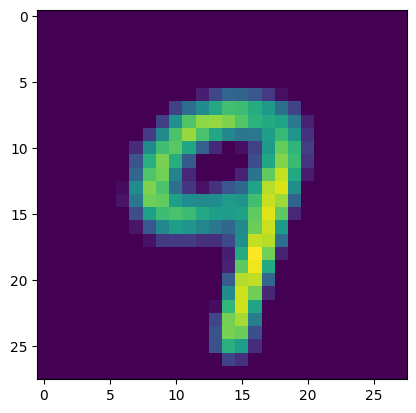

In [64]:
random_input = [0.1, 1.8]
out = decode(random_input)
out = out.reshape(28, 28)
plt.imshow(out)